# Visualization of Interpolation with Fractional Compression Factors

In [3]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def read_losses(file_path):
    """Helper to read loss values from a text file"""
    with open(file_path, 'r') as f:
        losses = [float(line.strip()) for line in f]
    return losses

def process_losses(folder_path):
    """Helper to process training and validation losses for a given folder"""
    # Use glob to find all matching files with wildcard patterns
    training_losses_files = glob.glob(os.path.join(folder_path, 'training_losses*.txt'))
    validation_losses_files = glob.glob(os.path.join(folder_path, 'validation_losses*.txt'))
    
    if training_losses_files and validation_losses_files:
        # Get the first matching files
        training_losses_file = training_losses_files[0]
        validation_losses_file = validation_losses_files[0]
        
        # Read loss values
        training_losses = read_losses(training_losses_file)
        validation_losses = read_losses(validation_losses_file)
        
        # If validation losses are longer than training losses, remove the first loss (model initialization)
        if len(validation_losses) > len(training_losses):
            validation_losses = validation_losses[1:]

        # Return processed loss values
        return training_losses, validation_losses
    
    return None, None

def compare_losses(folder_info):
    """
    Compare training and validation losses for multiple folder paths and return a summary DataFrame.
    
    Parameters:
        folder_info (list of tuples): Each tuple should contain (folder_path, description).
        
    Returns:
        pd.DataFrame: A DataFrame summarizing the loss metrics for each experiment.
    """
    results = []
    
    for folder_path, description in folder_info:
        # Process losses for the folder using the existing helper function
        training_losses, validation_losses = process_losses(folder_path)
        
        if training_losses and validation_losses:
            # Calculate minimum losses for training and validation
            min_train_loss = min(training_losses)
            min_val_loss = min(validation_losses)
            
            # Calculate the difference between validation and training losses for each epoch
            diffs = [v - t for v, t in zip(validation_losses, training_losses)]
            max_diff = max(diffs)
            min_diff = min(diffs)
            avg_diff = sum(diffs) / len(diffs)
            
            results.append({
                'Description': description,
                'Min Train Loss': "{:.3e}".format(min_train_loss),
                'Min Val Loss': "{:.3e}".format(min_val_loss),
                'Max Diff (Val-Train)': "{:.3e}".format(max_diff),
                'Min Diff (Val-Train)': "{:.3e}".format(min_diff),
                'Avg Diff (Val-Train)': "{:.3e}".format(avg_diff)
            })
        else:
            print(f"Warning: No matching loss files found in {folder_path}")
    
    results_df = pd.DataFrame(results)
    return results_df


def plot_losses(folder_info):
    """
    Visualize training and validation losses for multiple folder paths side by side.
    
    Parameters:
        folder_info (list of tuples): Each tuple should contain (folder_path, title)
    """
    num_folders = len(folder_info)
    # Create subplots: adjust the figure size based on the number of folders
    fig, axes = plt.subplots(1, num_folders, figsize=(5 * num_folders, 6), sharey=True)
    
    # If there's only one folder, axes is not a list so we wrap it
    if num_folders == 1:
        axes = [axes]
    
    for ax, (folder_path, title) in zip(axes, folder_info):
        training_losses, validation_losses = process_losses(folder_path)
        if training_losses and validation_losses:
            epochs = range(1, len(training_losses) + 1)
            ax.plot(epochs, training_losses, label='Training Loss', color="blue")
            ax.plot(epochs, validation_losses, label='Validation Loss', color="green")
            ax.set_title(title)
            ax.set_xlabel('Epoch')
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True)
        else:
            print(f"Warning: Missing loss files in {folder_path}")
    
    plt.tight_layout()
    # plt.savefig("losses_comparison.png", dpi=400)
    plt.show()



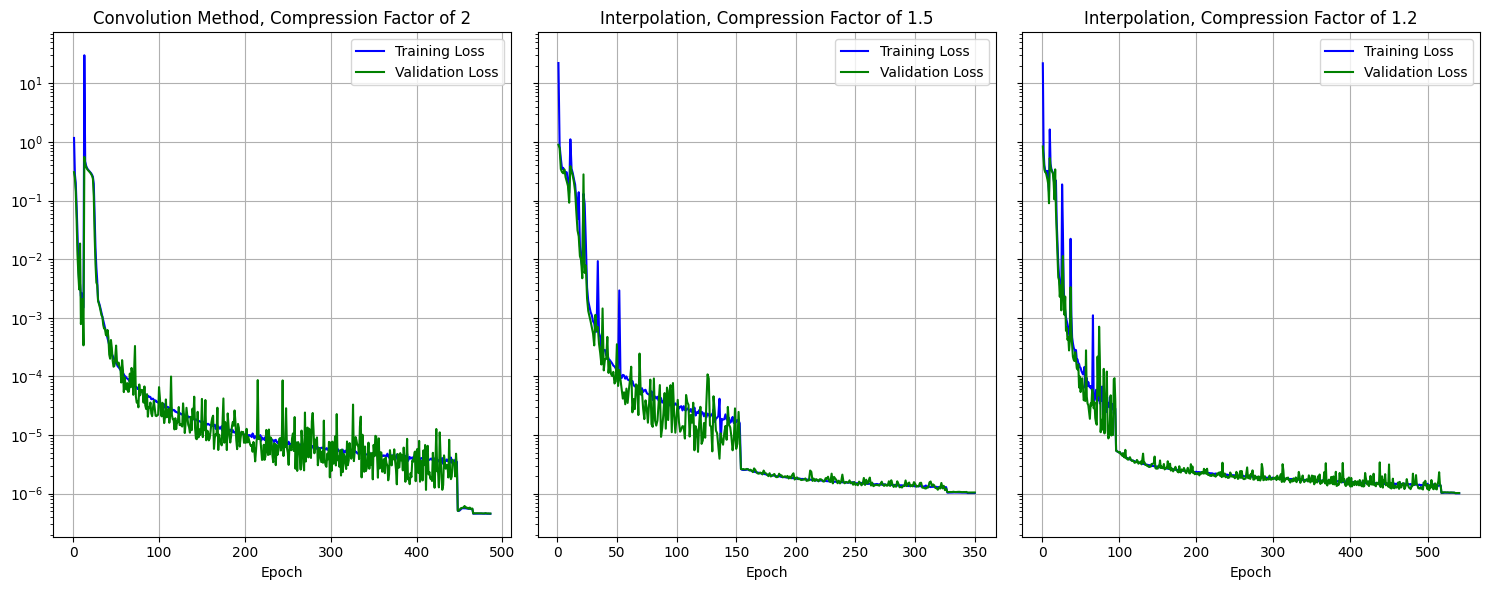

In [5]:
folder_paths = [
    ('/home/emilytong/ae_models/dataset1_64_class', 'Convolution Method, Compression Factor of 2'),
    ('/net/projects/fermi-1/autoencoders/dataset1/ae_models/interp1.5/dataset1_phot_AE_64-64-64-64_0.0004', 'Interpolation, Compression Factor of 1.5'),
    ('/net/projects/fermi-1/autoencoders/dataset1/ae_models/interp1.2/dataset1_phot_AE_64-64-64-64_0.0004', 'Interpolation, Compression Factor of 1.2')
]
plot_losses(folder_paths)

In [6]:
compare_losses(folder_paths)

,Description,Min Train Loss,Min Val Loss,Max Diff (Val-Train),Min Diff (Val-Train),Avg Diff (Val-Train)
0,"Convolution Method, Compression Factor of 2",4.533e-07,4.577e-07,1.477e-02,-2.964e+01,-6.360e-02
1,"Interpolation, Compression Factor of 1.5",1.024e-06,1.045e-06,1.495e-01,-2.136e+01,-6.545e-02
2,"Interpolation, Compression Factor of 1.2",1.012e-06,1.023e-06,1.566e-01,-2.116e+01,-4.291e-02
